In [1]:
import os
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

# Точность и полнота

In [2]:
data = pd.read_csv('../results/snr_tulip_noise_model.csv')
data.head()

,HM,Peaks source,Percentage of reads in peaks,Peakcaller,Precision,Recall,SNR
0,h3k4me1,encode,10.00%,macs2,100.00%,46.41%,36
1,h3k4me1,encode,10.00%,span,99.79%,76.57%,36
2,h3k4me1,encode,10.00%,sicer,99.99%,68.47%,36
3,h3k4me1,encode,5.00%,macs2,100.00%,29.35%,22
4,h3k4me1,encode,5.00%,span,99.74%,60.50%,22


In [3]:
data['Precision'] = data['Precision'].apply(lambda x: float(x.replace('%', '')))
data['Recall'] = data['Recall'].apply(lambda x: float(x.replace('%', '')))
data['Percentage of reads in peaks'] = data['Percentage of reads in peaks']\
                                      .apply(lambda x: float(x.replace('%', '')))

In [4]:
def scatter_by_peaks_source(source, t):
    plt.figure(figsize=(7, 5))
    
    min_p, max_p = t.where(t['Peaks source'] == source).dropna()['Precision'].min(),\
      t.where(t['Peaks source'] == source).dropna()['Precision'].max()
    min_r, max_r = t.where(t['Peaks source'] == source).dropna()['Recall'].min(),\
      t.where(t['Peaks source'] == source).dropna()['Recall'].max()

    for pc in ['span', 'sicer', 'macs2']:
        plt.ylim([min_p - 2, max_p + 2])
        plt.xlim([3, 59])
        subset = t.loc[(t['Peaks source'] == source) & (t['Peakcaller'] == pc)]
        plt.scatter(subset['SNR'], subset['Precision'])
        
    plt.ylabel('recall', fontsize=15)
    plt.xlabel('signal-to-noise ratio', fontsize=15)
    plt.legend(['span', 'sicer', 'macs2'], title='PEAK CALLER:', fontsize=13)
    plt.title(f"Peak source: {source.upper()}", fontsize=15)
    plt.show()
    
    plt.figure(figsize=(7, 5))
    for pc in ['span', 'sicer', 'macs2']:
        plt.ylim([min_r - 2, max_r + 2])
        plt.xlim([3, 59])
        subset = t.loc[(t['Peaks source'] == source) & (t['Peakcaller'] == pc)]
        plt.scatter(subset['SNR'], subset['Recall'])
        
    plt.ylabel('recall', fontsize=15)
    plt.xlabel('signal-to-noise ratio', fontsize=15)
    plt.legend(['span', 'sicer', 'macs2'], title='PEAK CALLER:', fontsize=13)
    plt.title(f"Peak source: {source.upper()}", fontsize=15)
    plt.show()

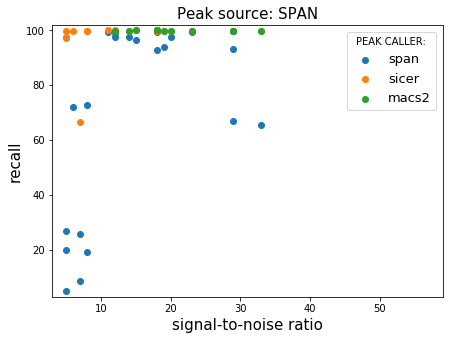

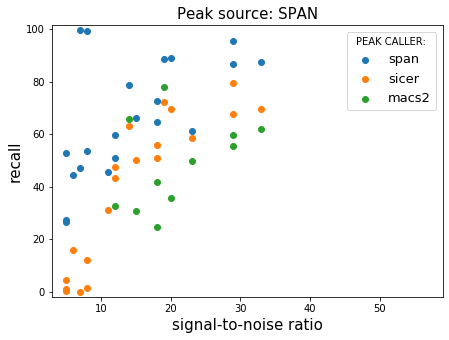

In [5]:
scatter_by_peaks_source('span', data)

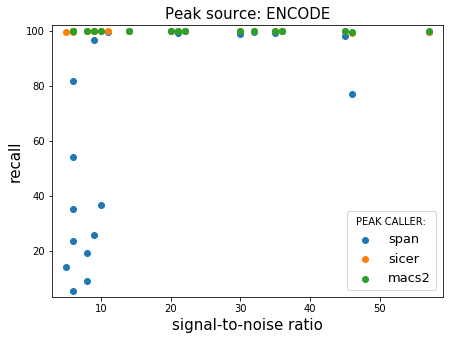

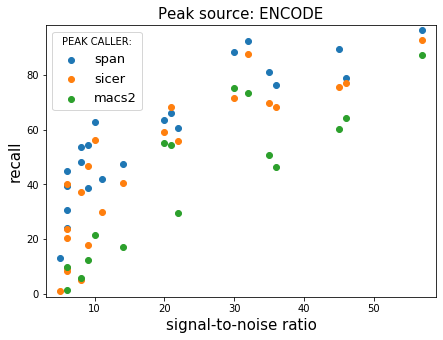

In [6]:
scatter_by_peaks_source('encode', data)

In [7]:
def curve_precision(x, a, b):
    return 100 + a / (x - b)

In [8]:
def curve_recall(x, a, b):
    return np.sqrt(a * x) + b

In [9]:
def plot_by_peaks_source(source, t):
    plt.figure(figsize=(7, 5))
    
    min_p, max_p = t.where(t['Peaks source'] == source).dropna()['Precision'].min(),\
      t.where(t['Peaks source'] == source).dropna()['Precision'].max()
    min_r, max_r = t.where(t['Peaks source'] == source).dropna()['Recall'].min(),\
      t.where(t['Peaks source'] == source).dropna()['Recall'].max()

    for pc in ['span', 'sicer', 'macs2']:
        plt.ylim([min_p - 2, max_p + 2])
        plt.xlim([3, 59])
        subset = t.loc[(t['Peaks source'] == source) & (t['Peakcaller'] == pc)]
        
        popt, pcov = curve_fit(curve_precision, subset['SNR'].values, subset['Precision'].values,
                          bounds=([-100, 0], [1, 30]),
                          p0=[1,0])
        xx = []
        if popt[1] < 3:
            xx = [i / 10 for i in range(0, 1001)]
            if popt[1] in xx:
                xx.remove(popt[1])
        else:
            for i in range(1, 100001):
                xx.append(popt[1] + i / 1000)
            
        plt.plot(xx, [curve_precision(x, *popt) for x in xx])
        
        plt.ylabel('precision', fontsize=15)
        plt.xlabel('signal-to-noise ratio', fontsize=15)
    plt.legend(['span', 'sicer', 'macs2'], title='PEAK CALLER:', fontsize=13)
    plt.title(f"Peak source: {source.upper()}", fontsize=15)
    plt.show()
    
    plt.figure(figsize=(7, 5))
    for pc in ['span', 'sicer', 'macs2']:
        plt.ylim([min_r - 2, 102])
        plt.xlim([-1, 59])
        subset = t.loc[(t['Peaks source'] == source) & (t['Peakcaller'] == pc)]
        
        popt, pcov = curve_fit(curve_recall, subset['SNR'].values, subset['Recall'].values,
                          bounds=([0, -np.inf], [np.inf, np.inf]),
                          p0=[0.4, 0])
        xx = []
        for i in range(1, 100001):
            xx.append( i / 1000)
            
        plt.plot(xx, [curve_recall(x, *popt) for x in xx])
        
        plt.ylabel('recall', fontsize=15)
        plt.xlabel('signal-to-noise ratio', fontsize=15)
    plt.legend(['span', 'sicer', 'macs2'], title='PEAK CALLER:', fontsize=13)
    plt.title(f"Peak source: {source.upper()}", fontsize=15)
    plt.show()

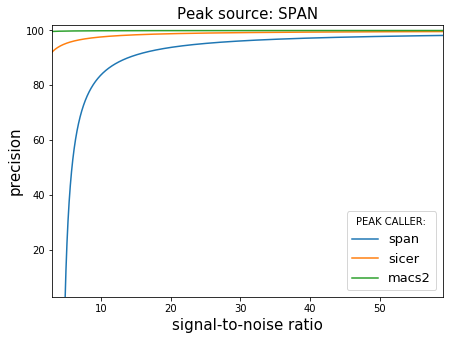

/home/snyss/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


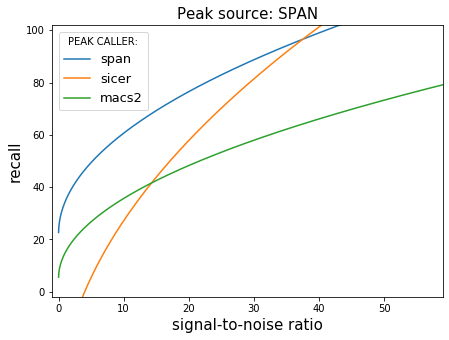

In [10]:
plot_by_peaks_source('span', data)

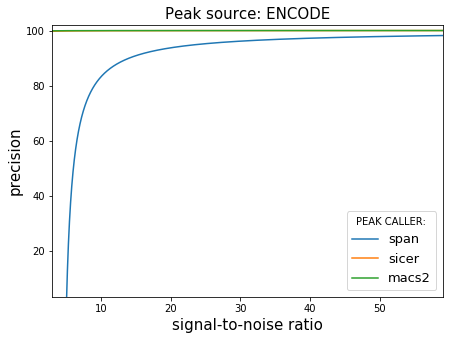

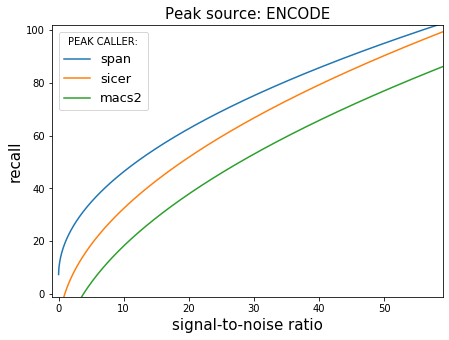

In [11]:
plot_by_peaks_source('encode', data)

# Изменение параметров модели Tulip при зашумлении с помощью аддитивной модели

In [12]:
alpha = lambda f, s: np.asarray(s)*(1-np.asarray(f))/np.asarray(f)/(1-np.asarray(s)) 

In [13]:
data_add_model = pd.read_csv('../results/snr_additive_noise_model.csv', sep='\t')
data_add_model.head()

,HM,Percentage of control reads,SNR
0,h3k4me1,0.0,33
1,h3k4me1,0.1,29
2,h3k4me1,0.2,25
3,h3k4me1,0.3,22
4,h3k4me1,0.4,19


In [14]:
def read_model(hm, folder):
    f_dynamics, s_dynamics, pcr_rate_dynamics = [], [], []
    
    for i in range(10):
        fname = f'../tulip_models/{folder}/{hm}_{i}.json'
        if os.path.isfile(fname):
            with open(fname) as tulip_output:
                tulip_model = json.load(tulip_output)
                f_dynamics.append(tulip_model["pulldown"]["f"])
                s_dynamics.append(tulip_model["pulldown"]["s"])
                pcr_rate_dynamics.append(tulip_model["pcr_rate"])
                
    return f_dynamics, s_dynamics, pcr_rate_dynamics

In [15]:
def plot_dynamics(folder, name):
    ss = []
    fs = []
    plt.figure(figsize=(7, 5))
    for hm in ['h3k4me1', 'h3k4me3', 'h3k27ac', 'h3k27me3', 'h3k36me3']:
        f, s, _ = read_model(hm, folder)
        ss.append(s)
        fs.append(f)
        plt.plot([j/10 for j in range(10)], s)
    plt.legend(['h3k4me1', 'h3k4me3', 'h3k27ac', 'h3k27me3', 'h3k36me3'])
    plt.ylabel(f'P(B|D) - measure of the antibody specificity', fontsize=13)
    plt.xlabel('% of reads from control', fontsize=14)
    plt.title(f'Источник пиков: {name}')
    plt.show()
    
    plt.figure(figsize=(7, 5))
    for (f, s) in zip(fs, ss):
        plt.plot([j/10 for j in range(10)], alpha(f, s))
    plt.legend(['h3k4me1', 'h3k4me3', 'h3k27ac', 'h3k27me3', 'h3k36me3'])
    plt.ylabel(f'P(D|B) / '+r'$P(D|\overline{B})$'+f' - measure of the\nantibody efficiency', fontsize=13)
    plt.xlabel('% of reads from control', fontsize=14)
    plt.title(f'Источник пиков: {name}')
    plt.show()

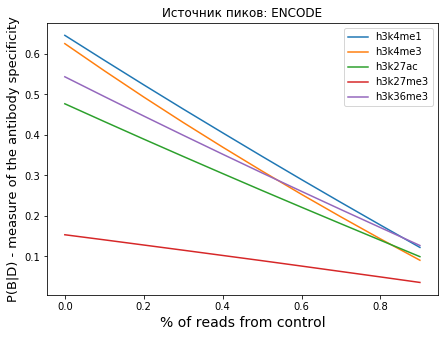

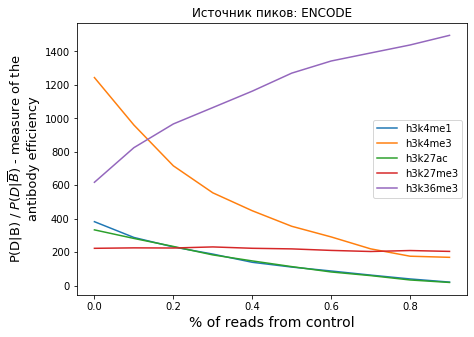

In [16]:
plot_dynamics('peaks_from_encode', 'ENCODE')

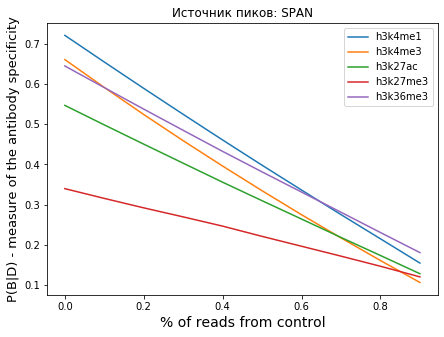

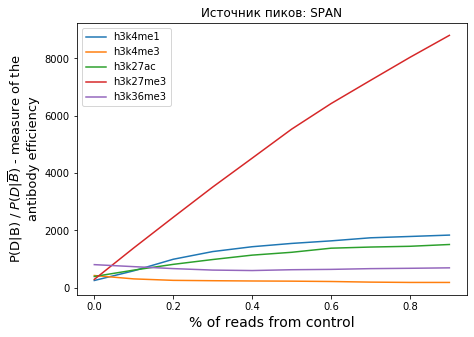

In [17]:
plot_dynamics('peaks_from_span', 'SPAN')

# Зависимость между SNR и долей ридов внутри пиков 

In [18]:
def plot_snr_dynamics(folder, peaks):
    plt.figure(figsize=(7, 5))
    for hm in ['h3k4me1', 'h3k4me3', 'h3k27ac', 'h3k27me3', 'h3k36me3']:
        _, s, _ = read_model(hm, folder)
        snr = data_add_model.loc[data_add_model.HM == hm].SNR.values[:len(s)]
        plt.plot(snr, s)
    plt.ylim([0, 0.76])
    plt.xlim([0, 77])
    plt.xlabel('Signal-to-noise ratio', fontsize=14)
    plt.ylabel('P(B|D) - measure of antibody specificity', fontsize=14)
    plt.legend([f'{hm} {peaks}' 
                for hm in ['h3k4me1', 'h3k4me3', 'h3k27ac', 'h3k27me3', 'h3k36me3']])
    plt.title('Источник шума: риды из контроля', fontsize=14)
    plt.show()
    
    plt.figure(figsize=(7, 5))
    for hm in ['h3k4me1', 'h3k4me3', 'h3k27ac', 'h3k27me3', 'h3k36me3']:
        subset = data.loc[(data['Peaks source'] == peaks)
                         & (data.HM == hm)][['Percentage of reads in peaks', 'SNR']]\
                     .drop_duplicates()
        plt.plot(subset.SNR, subset['Percentage of reads in peaks'] / 100)
    plt.ylim([0, 0.76])
    plt.xlim([0, 77])
    plt.xlabel('Signal-to-noise ratio', fontsize=14)
    plt.ylabel('P(B|D) - measure of antibody specificity', fontsize=14)
    plt.legend([f'{hm} {peaks}' 
                for hm in ['h3k4me1', 'h3k4me3', 'h3k27ac', 'h3k27me3', 'h3k36me3']])
    plt.title('Источник шума: модель TULIP', fontsize=14)
    plt.show()

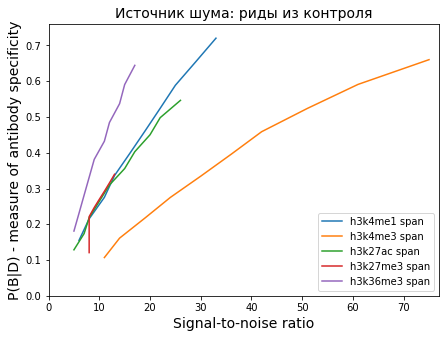

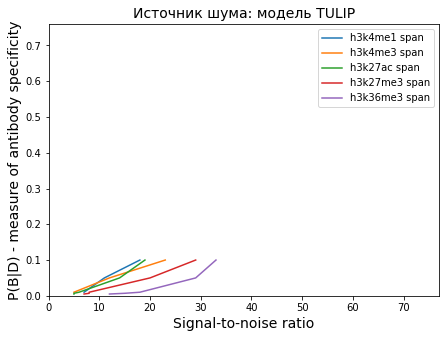

In [19]:
plot_snr_dynamics('peaks_from_span', 'span')

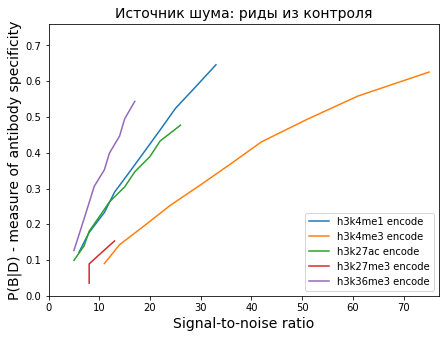

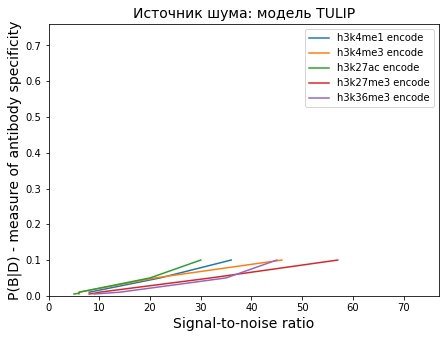

In [20]:
plot_snr_dynamics('peaks_from_encode', 'encode')